## 市场相对轮动图

*对市场内股票数据进行统计，观察样本变化。*

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pymongo
import pandas as pd
from datetime import datetime

In [3]:
symbolList = ['btc_usdt.spot:binance', 'eth_usdt.spot:binance', 'bnb_usdt.spot:binance', 'ltc_usdt.spot:binance','bch_usdt.spot:binance',
             'doge_usdt.spot:binance', 'matic_usdt.spot:binance', 'sol_usdt.spot:binance','link_usdt.spot:binance','uni_usdt.spot:binance']

client = pymongo.MongoClient('172.16.20.81', 27017)

In [4]:
def readDb(collection, start, end):
    return pd.DataFrame(
        list(collection.find({"datetime": {'$gt': start, '$lt': end}}))
    )

In [5]:
startTime = datetime(2022,9,1)
endTime = datetime(2023,1,2)
dbClient = client['Kline_1Min_Auto_Db_Plus']
columnsName = ['open', 'high', 'low', 'close', 'volume','datetime']

In [6]:
crytoDict = {
                'btc':readDb(dbClient[symbolList[0]], start=startTime , end=endTime)[columnsName],
                'eth':readDb(dbClient[symbolList[1]], start=startTime , end=endTime)[columnsName],
                'bnb':readDb(dbClient[symbolList[2]], start=startTime , end=endTime)[columnsName],
                'ltc':readDb(dbClient[symbolList[3]], start=startTime , end=endTime)[columnsName],
                'bch':readDb(dbClient[symbolList[4]], start=startTime , end=endTime)[columnsName],
                'doge':readDb(dbClient[symbolList[5]], start=startTime , end=endTime)[columnsName],
                'matic':readDb(dbClient[symbolList[6]], start=startTime , end=endTime)[columnsName],
                'sol':readDb(dbClient[symbolList[7]], start=startTime , end=endTime)[columnsName],
                'link':readDb(dbClient[symbolList[8]], start=startTime , end=endTime)[columnsName],
                'uni':readDb(dbClient[symbolList[9]], start=startTime , end=endTime)[columnsName],
            }

In [7]:
# crytoDict

In [8]:
def resampleDf(data, freq='D'):
#     df = data.drop('_id', axis=1)
    dataDf = df.set_index('datetime')
    dataDf.resample(freq).agg({'open':'first', 'high': 'max', 'low': 'min', 'close': 'last', 'volume':'sum'})
    dataResetDf = dataDf.reset_index()
    return dataResetDf

In [9]:
def addSymbol(dataDf, symbolName):
    dataDf['symbol'] = symbolName
    return dataDf

In [10]:
def setIndex(dataDf):
    dataIndex = dataDf.set_index(['datetime', 'symbol'])
    return dataIndex

In [11]:
multiCryptoDict = {}
for key, df in crytoDict.items():
    hourDf = resampleDf(df)
    hourSymbolDf = addSymbol(hourDf, key)
    hourIndexDf = setIndex(hourSymbolDf)
    multiCryptoDict[key] = hourIndexDf

In [12]:
multiDf = pd.concat(list(multiCryptoDict.values())).sort_index()

In [13]:
multiDf

open        high          low        close  \
datetime            symbol                                                      
2022-09-01 00:01:00 bch       116.40000    116.4000    116.30000    116.30000   
                    bnb       282.40000    282.6000    282.40000    282.40000   
                    btc     20159.30000  20188.9700  20155.58000  20171.81000   
                    doge        0.06219      0.0622      0.06214      0.06215   
                    eth      1562.23000   1565.2900   1562.22000   1563.38000   
...                                 ...         ...          ...          ...   
2023-01-01 23:59:00 link        5.60000      5.6010      5.59500      5.59500   
                    ltc        70.38000     70.3800     70.36000     70.36000   
                    matic       0.75850      0.7586      0.75830      0.75850   
                    sol         9.85000      9.8700      9.85000      9.87000   
                    uni         5.21100      5.2110      5.20900      5.20900   

                                  volume  
datetime            symbol                
2022-09-01 00:01:00 bch         12.37800  
                    bnb        405.06400  
                    btc        460.88112  
                    doge    145173.00000  
                    eth       1187.24970  
...                                  ...  
2023-01-01 23:59:00 link       355.68000  
                    ltc         57.20400  
                    matic    15291.40000  
                    sol       2606.35000  
                    uni        227.99000  

[1771190 rows x 5 columns]

In [14]:
closePrice = multiDf['close'].unstack()

In [15]:
rsDf = pd.DataFrame({name: closePrice[name]/closePrice['btc']*100 for name in closePrice.columns})
rsDf['btc'] = closePrice['btc']

In [28]:
periodParam = 20

In [29]:
normalizationRS = 100+ (rsDf -rsDf.rolling(periodParam).mean())/rsDf.rolling(periodParam).std()

<AxesSubplot:xlabel='datetime'>

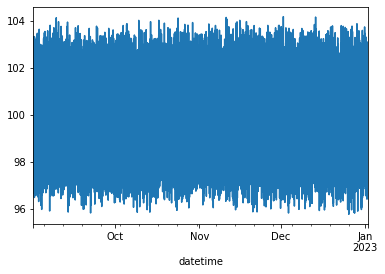

In [30]:
normalizationRS.btc.plot()

In [31]:
RS_Mom = normalizationRS.pct_change()
jdk_rs_mom = 100+(RS_Mom - RS_Mom.rolling(periodParam).mean())/RS_Mom.rolling(periodParam).std()

<AxesSubplot:xlabel='datetime'>

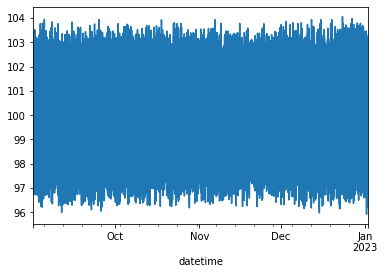

In [32]:
jdk_rs_mom.btc.plot()

In [33]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def setup_plot(fig, ax):
    ax.set_title("Relative Rotation Graph")
    ax.set_xlabel("RS-Ratio")
    ax.set_ylabel("RS-Momentum")
    plt.figtext(0.14, 0.14, "Lagging", color="red")
    plt.figtext(0.14, 0.84, "Improving", color="blue")
    plt.figtext(0.87, 0.84, "Leading", color="green", ha="right")
    plt.figtext(0.87, 0.14, "Weakening", color="gold", ha="right")
    windowZoom = 10
    lim = [100 - windowZoom, 100 + windowZoom]
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    ax.axhline(y=100, color="gray", linewidth=0.5)
    ax.axvline(x=100, color="gray", linewidth=0.5)
    rect = patches.Rectangle((0, 0), 100, 100, facecolor="red", alpha=0.2)
    ax.add_patch(rect)
    rect = patches.Rectangle((0, 100), 100, 100, facecolor="blue", alpha=0.2)
    ax.add_patch(rect)
    rect = patches.Rectangle((100, 100), 100, 100, facecolor="green", alpha=0.2)
    ax.add_patch(rect)
    rect = patches.Rectangle((100, 0), 100, 100, facecolor="yellow", alpha=0.2)
    ax.add_patch(rect)
    plt.gcf().set_size_inches(10, 10)

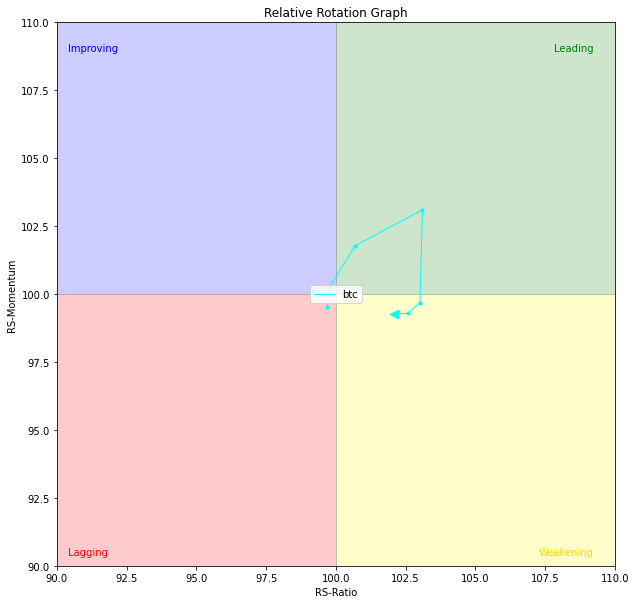

In [38]:
fig, ax = plt.subplots()
setup_plot(fig, ax)
ax.plot(
    normalizationRS.btc.iloc[-7:],
    jdk_rs_mom.btc.iloc[-7:],
    color='cyan',
    linewidth=1,
    label='btc'
)
ax.scatter(normalizationRS.btc.iloc[-7:-1], jdk_rs_mom.btc.iloc[-7:-1], c='cyan', marker='o', s=10)
ax.scatter(normalizationRS.btc.iloc[-1:], jdk_rs_mom.btc.iloc[-1:], c='cyan', marker='<', s=80)
ax.legend(loc='center')

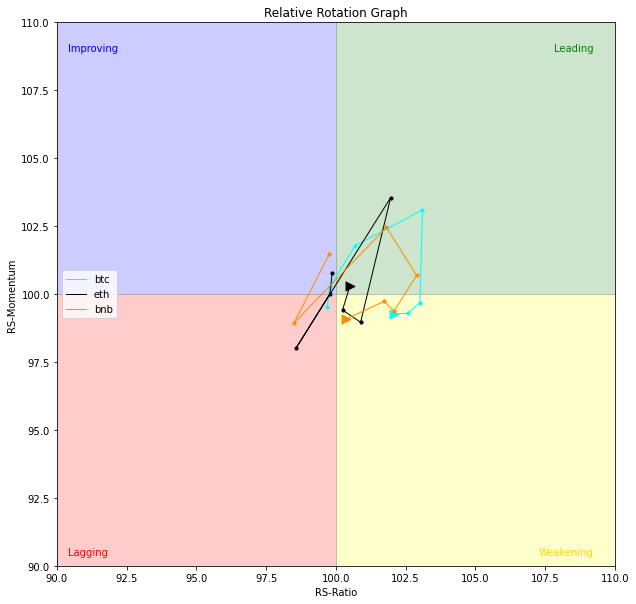

In [37]:
symbolColor = {'btc': 'cyan', 'eth': 'black', 'bnb': 'darkorange'}
fig, ax = plt.subplots()
setup_plot(fig, ax)
for symbol, color in symbolColor.items():
    ax.plot(
        normalizationRS[symbol].iloc[-7:],
        jdk_rs_mom[symbol].iloc[-7:],
        color=color,
        linewidth=1,
        label=symbol
    )
    ax.scatter(normalizationRS[symbol].iloc[-7:-1], jdk_rs_mom[symbol].iloc[-7:-1], c=color, marker='o', s=10)
    ax.scatter(normalizationRS[symbol].iloc[-1:], jdk_rs_mom[symbol].iloc[-1:], c=color, marker='>', s=80)
    ax.legend(loc='center left')